In [1]:
library(ggplot2)
library(survival)
library(survminer)
library(forestplot)
library(meta)
library(epitools)

Loading required package: ggpubr

Loading required package: grid

Loading required package: magrittr

Loading required package: checkmate

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Loading 'meta' package (version 6.2-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
older version of 'meta' package: https://tinyurl.com/dt4y5drs


Attaching package: ‘epitools’


The following object is masked from ‘package:survival’:

    ratetable




In [2]:
All = readRDS("/srv/shiny-server/SNVIO_V7/Refence_datasets_COX.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")
datasets_mu = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_mutation_with_therapy.rds")

In [3]:
datasets_overview = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/datasets_overview.csv",quote = "")
datasets_names = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F,row.names = 1)
colnames(datasets_names) = "Cohort_name"
datasets_overview = cbind(datasets_names,datasets_overview)
datasets_overview = datasets_overview[names(All),]

datasets_overview$OS = FALSE
datasets_overview$PFS = FALSE
datasets_overview$RECIST = FALSE
datasets_overview$RESPONSE = FALSE
datasets_overview$TMB = FALSE
datasets_overview$RNA = FALSE
for(i in rownames(datasets_overview)){
    if( "OS_TIME" %in% colnames(All[[i]]) ){datasets_overview[i,"OS"] = TRUE}
    if( "PFS_TIME" %in% colnames(All[[i]]) ){datasets_overview[i,"PFS"] = TRUE}
    if( "RECIST" %in% colnames(All[[i]]) ){datasets_overview[i,"RECIST"] = TRUE}
    if( "RESPONSE" %in% colnames(All[[i]]) ){datasets_overview[i,"RESPONSE"] = TRUE}
    if( "TMB" %in% colnames(All[[i]]) ){datasets_overview[i,"TMB"] = TRUE}
}

In [4]:
dataset_meta = read.csv("/home/ncpsb/new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F)
dataset_name = dataset_meta$V2
names(dataset_name) = dataset_meta$V1

In [5]:
datasets_names$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_names$Cohort_name)
datasets_overview$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_overview$Cohort_name)

dataset_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",dataset_name)

In [6]:
ref_cohort_cal_TMB = function(dataset,cutoff_ratio = 0.5){
  

    tmp_data = All[[dataset]]
    cutoff = quantile(na.omit(tmp_data[,"TMB"]),probs = 1-cutoff_ratio,na.rm = T)
    low = rownames(tmp_data)[!is.na(tmp_data[,"TMB"])][ na.omit(tmp_data[,"TMB"]) < cutoff]
    high = rownames(tmp_data)[!is.na(tmp_data[,"TMB"])][ na.omit(tmp_data[,"TMB"]) >= cutoff]
  
  return(list("low"=low,"high"=high))
  
}

ref_cohort_cal_pm = function(dataset,pathway,dataset_mu,Mut_type,Wild_type){
  
  genes = intersect(colnames(dataset),pathway_list[[pathway]])
  
  if("All" %in% Mut_type){
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes
    ])
    
  }else{
    
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes & 
        dataset_mu$Variant_Classification %in% Mut_type
    ])
    
    
    
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),mut)
  }else{
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),unique(dataset_mu$ID[dataset_mu$Hugo_Symbol %in% genes]))
  }
  
  return(list("mut"=mut,"wt"=wt))
  
}

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  2,3 ; coefficient may be infinite. ”


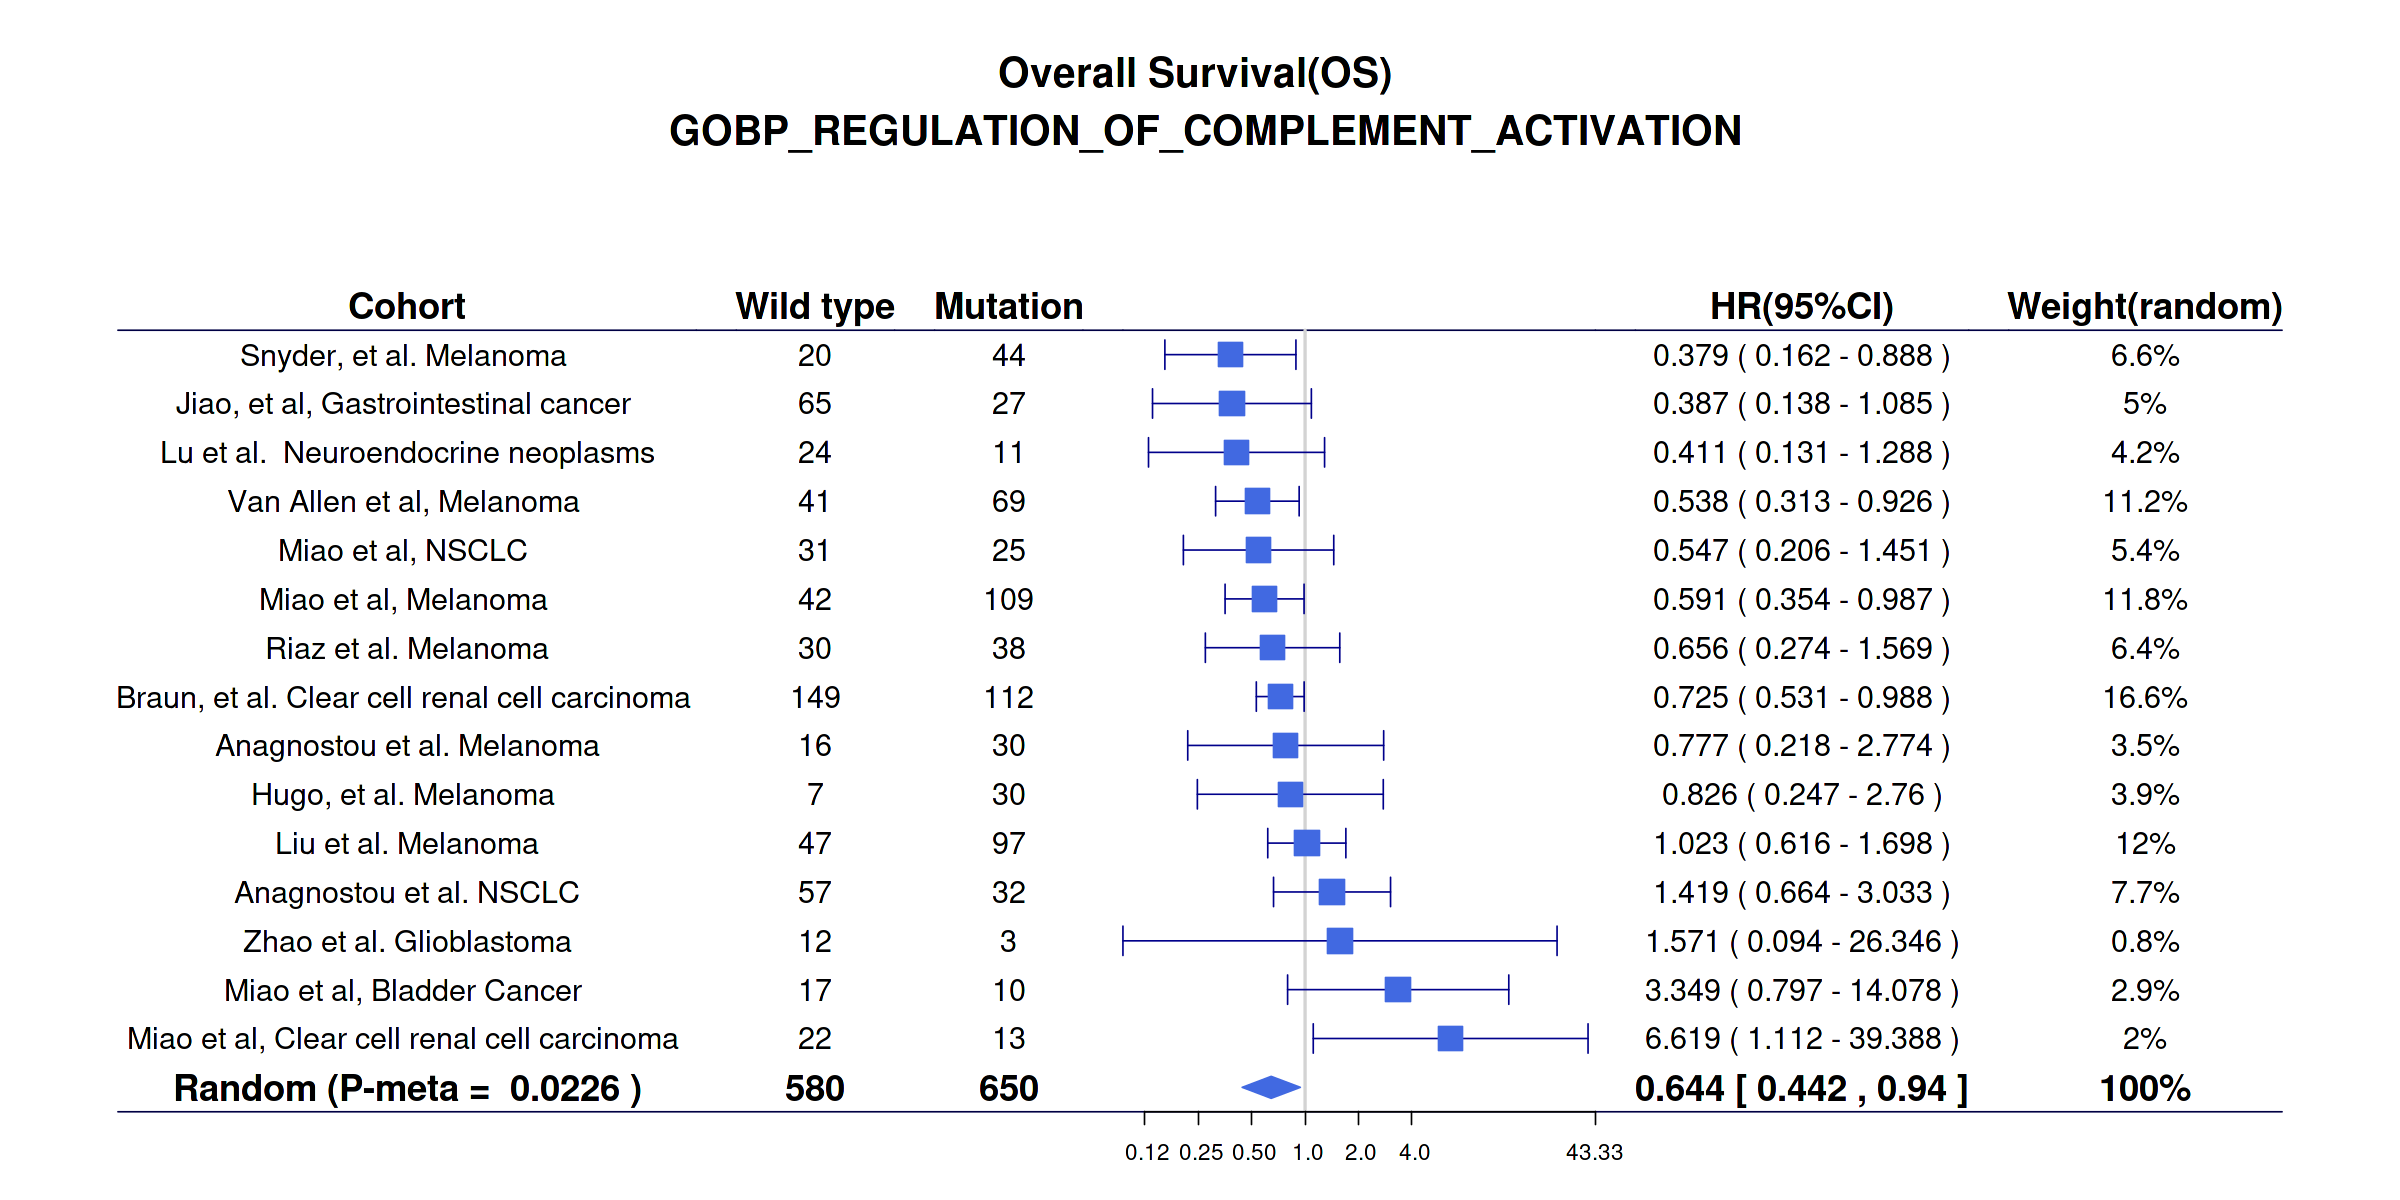

In [8]:
TMB_cutoff = 0.3
cohort = vector()
wildtype = vector()
mutation = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    
    if("OS_TIME" %in% colnames(All[[i]])){
        
        tmp_data = All[[i]]
        newdata =tmp_data[,c("OS_TIME","OS_STATUS")]
        
        genes = intersect(colnames(tmp_data),pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]])
        newdata$Complement = ifelse(rowSums(tmp_data[,genes] == "Mutation") >0, "Mutation","Wildtype")
        newdata$Complement = factor(newdata$Complement,levels = c("Wildtype","Mutation"))
        
#         wildtype = c(wildtype,table(newdata$Complement)[1])
#         mutation = c(mutation,table(newdata$Complement)[2])
        
        newdata$BTMB = ifelse(tmp_data$TMB >= quantile(tmp_data$TMB,probs = 1-TMB_cutoff,na.rm = T),"TMB high","TMB low") # 二分化TMB
        newdata$BTMB = factor(newdata$BTMB,levels = c("TMB low","TMB high"))
        
        if("Age" %in% colnames(tmp_data) & !i %in% c("dataset3","dataset3.1","dataset3.2","dataset3.3")){
            
            newdata$BAge = ifelse(tmp_data$Age >= 65,"≥65","<65")
            
        }
        if("Gender" %in% colnames(tmp_data)){
            
            newdata$Gender = tmp_data$Gender
            
        }
        
        newdata = newdata[rowSums(is.na(newdata[,c("OS_TIME","OS_STATUS")])) == 0,]
        if(table(newdata$Complement)["Mutation"] >= 3 & table(newdata$Complement)["Wildtype"] >= 3 ){
            cohort = c(cohort,dataset_name[i])
            wildtype = c(wildtype,table(newdata$Complement)["Wildtype"])
            mutation = c(mutation,table(newdata$Complement)["Mutation"])

            coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~.,data = newdata))
            HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1]["ComplementMutation"],3))
            HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3]["ComplementMutation"],3))
            HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4]["ComplementMutation"],3))
            HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1]["ComplementMutation"],3),"(",round(summary(coxres)$conf.int[,3]["ComplementMutation"],3),"-",round(summary(coxres)$conf.int[,4]["ComplementMutation"],3),")"))
            waldtest = c(waldtest,round(summary(coxres)$coefficients["ComplementMutation","Pr(>|z|)"],3))
        }


    }
    
}


library(forestplot)
library(meta)

ord = order(HR_mean)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                  c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P-MultiVar",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))



tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))


if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.random,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.random,digits = 4),")")
    }


    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.common,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.common,digits = 4),")")
    }

}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)


tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")
options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2,clip = c(minlow-minlow/10,maxup+maxup/10),
                lty.ci = 1,
                ci.vertices.height = 0.3,
                align="c",
                graphwidth = unit(10,"cm"),
                lwd.zero = gpar(lwd=2,lty=2),
               txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 boxsize = 0.5,
                 graph.pos = 4,
                 title = paste("Overall Survival(OS)","\n","GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1,2 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


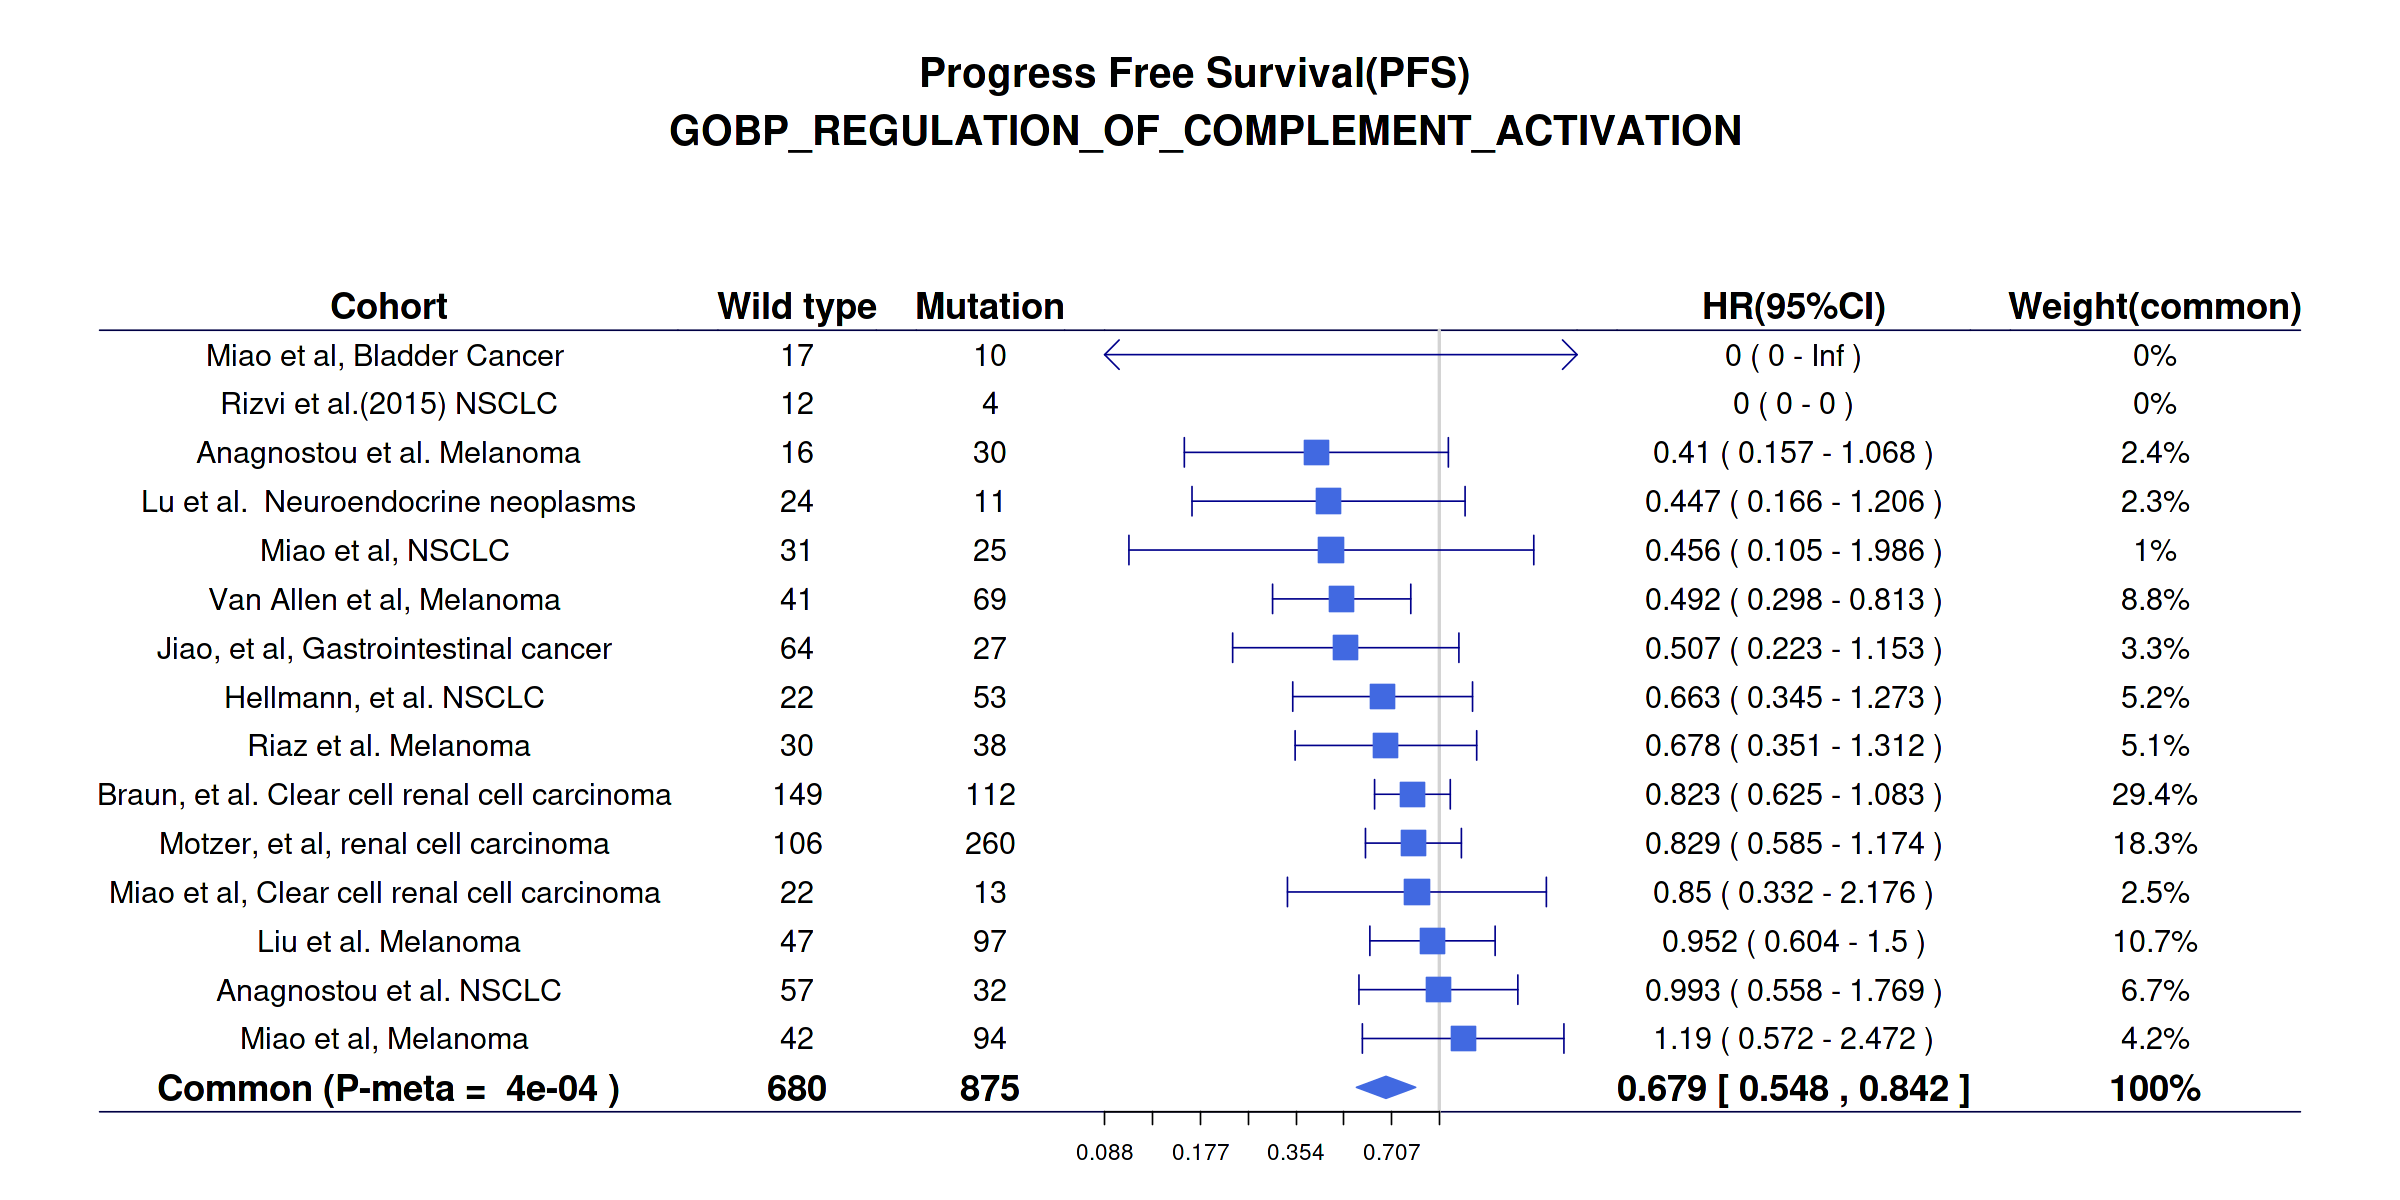

In [12]:
TMB_cutoff = 0.3
cohort = vector()
wildtype = vector()
mutation = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    
    if("PFS_TIME" %in% colnames(All[[i]])){
        
        tmp_data = All[[i]]
        newdata =tmp_data[,c("PFS_TIME","PFS_STATUS")]
        
        genes = intersect(colnames(tmp_data),pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]])
        newdata$Complement = ifelse(rowSums(tmp_data[,genes] == "Mutation") >0, "Mutation","Wildtype")
        newdata$Complement = factor(newdata$Complement,levels = c("Wildtype","Mutation"))
        
#         wildtype = c(wildtype,table(newdata$Complement)[1])
#         mutation = c(mutation,table(newdata$Complement)[2])

        newdata$BTMB = ifelse(tmp_data$TMB >= quantile(tmp_data$TMB,probs = 1-TMB_cutoff,na.rm = T),"TMB high","TMB low") # 二分化TMB
        newdata$BTMB = factor(newdata$BTMB,levels = c("TMB low","TMB high"))
        
        if("Age" %in% colnames(tmp_data) & !i %in% c("dataset3","dataset3.1","dataset3.2","dataset3.3")){
            
            newdata$BAge = ifelse(tmp_data$Age >= 65,"≥65","<65")
            
        }
        if("Gender" %in% colnames(tmp_data)){
            
            newdata$Gender = tmp_data$Gender
            
        }
        
        newdata = newdata[rowSums(is.na(newdata[,c("PFS_TIME","PFS_STATUS")])) == 0,]
        if(table(newdata$Complement)["Mutation"] >= 3 & table(newdata$Complement)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            wildtype = c(wildtype,table(newdata$Complement)["Wildtype"])
            mutation = c(mutation,table(newdata$Complement)["Mutation"])
            
            coxres <- do.call(coxph, list(Surv(PFS_TIME,PFS_STATUS)~.,data = newdata))
            HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1]["ComplementMutation"],3))
            HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3]["ComplementMutation"],3))
            HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4]["ComplementMutation"],3))
            HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1]["ComplementMutation"],3),"(",round(summary(coxres)$conf.int[,3]["ComplementMutation"],3),"-",round(summary(coxres)$conf.int[,4]["ComplementMutation"],3),")"))
            waldtest = c(waldtest,round(summary(coxres)$coefficients["ComplementMutation","Pr(>|z|)"],3))
            
        }

    }
    
}


library(forestplot)
library(meta)

ord = order(HR_mean)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                  c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P-MultiVar",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))



tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.random,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.random,digits = 4),")")
    }


    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.common,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.common,digits = 4),")")
    }

}

maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2,clip = c(minlow-minlow/10,maxup+maxup/10),
                lty.ci = 1,
                ci.vertices.height = 0.3,
                align="c",
                graphwidth = unit(10,"cm"),
                lwd.zero = gpar(lwd=2,lty=2),
               txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 boxsize = 0.5,
                 graph.pos = 4,
                 title = paste("Progress Free Survival(PFS)","\n","GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [185]:
TMB_cutoff = 0.3
cohort = vector()
NCB = vector()
DCB = vector()
OR_mean = vector()
OR_lower = vector()
OR_upper = vector()
OR_text = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    
    if("RESPONSE" %in% colnames(All[[i]])){
        
        tmp_data = All[[i]]
        newdata =tmp_data[c("RESPONSE")]
        
        genes = intersect(colnames(tmp_data),pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]])
        newdata$Complement = ifelse(rowSums(tmp_data[,genes] == "Mutation") >0, "Mutation","Wildtype")
        newdata$Complement = factor(newdata$Complement,levels = c("Wildtype","Mutation"))
        
#         wildtype = c(wildtype,table(newdata$Complement)[1])
#         mutation = c(mutation,table(newdata$Complement)[2])

        newdata$BTMB = ifelse(tmp_data$TMB >= quantile(tmp_data$TMB,probs = 1-TMB_cutoff,na.rm = T),"TMB high","TMB low") # 二分化TMB
        newdata$BTMB = factor(newdata$BTMB,levels = c("TMB low","TMB high"))
        
        if("Age" %in% colnames(tmp_data) & !i %in% c("dataset3","dataset3.1","dataset3.2","dataset3.3")){
            
            newdata$BAge = ifelse(tmp_data$Age >= 65,"≥65","<65")
            
        }
        if("Gender" %in% colnames(tmp_data)){
            
            newdata$Gender = tmp_data$Gender
            
        }
        
        newdata = newdata[rowSums(is.na(newdata[c("RESPONSE")])) == 0,]
        if(table(newdata$Complement)["Mutation"] >= 3 & table(newdata$Complement)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            contingency = table(newdata$Complement,newdata$RESPONSE)
            tmp_chi = chisq.test(contingency,correct = F)

            if(sum(tmp_chi$expected < 5) > 0){

                    rr_RESPONSE = oddsratio(contingency,correction = T,rev = "both",method = c( "fisher"))
            }else{

                    rr_RESPONSE = oddsratio(contingency,correction = F,rev = "both",method = c( "fisher"))
            }


           NCB = c(NCB,paste(rr_RESPONSE$data["Mutation","nonresponse"],rr_RESPONSE$data["Total","nonresponse"],sep = "/"))
           DCB = c(DCB,paste(rr_RESPONSE$data["Mutation","response"],rr_RESPONSE$data["Total","response"],sep = "/"))
            
            for(i in colnames(newdata)){
                newdata[[i]] = factor(newdata[[i]])
            }
            
            model = glm(RESPONSE~.,data=newdata,family = binomial)
            
            OR_mean = c(OR_mean,exp(coef(model))[2])
            OR_lower = c(OR_lower,exp(confint(model))[2,1])
            OR_upper = c(OR_upper,exp(confint(model))[2,2])
            OR_text = c(OR_text,paste(round(exp(coef(model))[2],digits = 3),"(",round(exp(confint(model))[2,1],digits = 3),"-",round(exp(confint(model))[2,2],digits = 3),")"))
            
        }

    }else if("RECIST" %in% colnames(All[[i]])){
        
        tmp_data = All[[i]]
        newdata =tmp_data[c("RECIST")]
        
        genes = intersect(colnames(tmp_data),pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]])
        newdata$Complement = ifelse(rowSums(tmp_data[,genes] == "Mutation") >0, "Mutation","Wildtype")
        newdata$Complement = factor(newdata$Complement,levels = c("Wildtype","Mutation"))
        
#         wildtype = c(wildtype,table(newdata$Complement)[1])
#         mutation = c(mutation,table(newdata$Complement)[2])

        newdata$BTMB = ifelse(tmp_data$TMB >= quantile(tmp_data$TMB,probs = 1-TMB_cutoff,na.rm = T),"TMB high","TMB low") # 二分化TMB
        newdata$BTMB = factor(newdata$BTMB,levels = c("TMB low","TMB high"))
        
        if("Age" %in% colnames(tmp_data) & !i %in% c("dataset3","dataset3.1","dataset3.2","dataset3.3")){
            
            newdata$BAge = ifelse(tmp_data$Age >= 65,"≥65","<65")
            
        }
        if("Gender" %in% colnames(tmp_data)){
            
            newdata$Gender = tmp_data$Gender
            
        }
        
        
        newdata = newdata[rowSums(is.na(newdata[c("RECIST")])) == 0,]
        if(table(newdata$Complement)["Mutation"] >= 3 & table(newdata$Complement)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            contingency = table(newdata$Complement,newdata$RECIST)
            tmp_chi = chisq.test(contingency,correct = F)

            if(sum(tmp_chi$expected < 5) > 0){

                    rr_RECIST = oddsratio(contingency,correction = T,rev = "row",method = c( "fisher"))
            }else{

                    rr_RECIST = oddsratio(contingency,correction = F,rev = "row",method = c( "fisher"))
            }


          NCB = c(NCB,paste(rr_RECIST$data["Mutation","PD/SD"],rr_RECIST$data["Total","PD/SD"],sep = "/"))
          DCB = c(DCB,paste(rr_RECIST$data["Mutation","CR/PR"],rr_RECIST$data["Total","CR/PR"],sep = "/"))
            
            for(i in colnames(newdata)){
                newdata[[i]] = factor(newdata[[i]])
            }
            
            newdata$Complement = factor(newdata$Complement,levels = c("Mutation","Wildtype"))
            
            model = glm(RECIST~.,data=newdata,family = binomial)
            
            OR_mean = c(OR_mean,exp(coef(model))[2])
            OR_lower = c(OR_lower,exp(confint(model))[2,1])
            OR_upper = c(OR_upper,exp(confint(model))[2,2])
            OR_text = c(OR_text,paste(round(exp(coef(model))[2],digits = 3),"(",round(exp(confint(model))[2,1],digits = 3),"-",round(exp(confint(model))[2,2],digits = 3),")"))
            
        }

    }
    
}

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Warning message in chisq.test(contingency, correct = F):

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

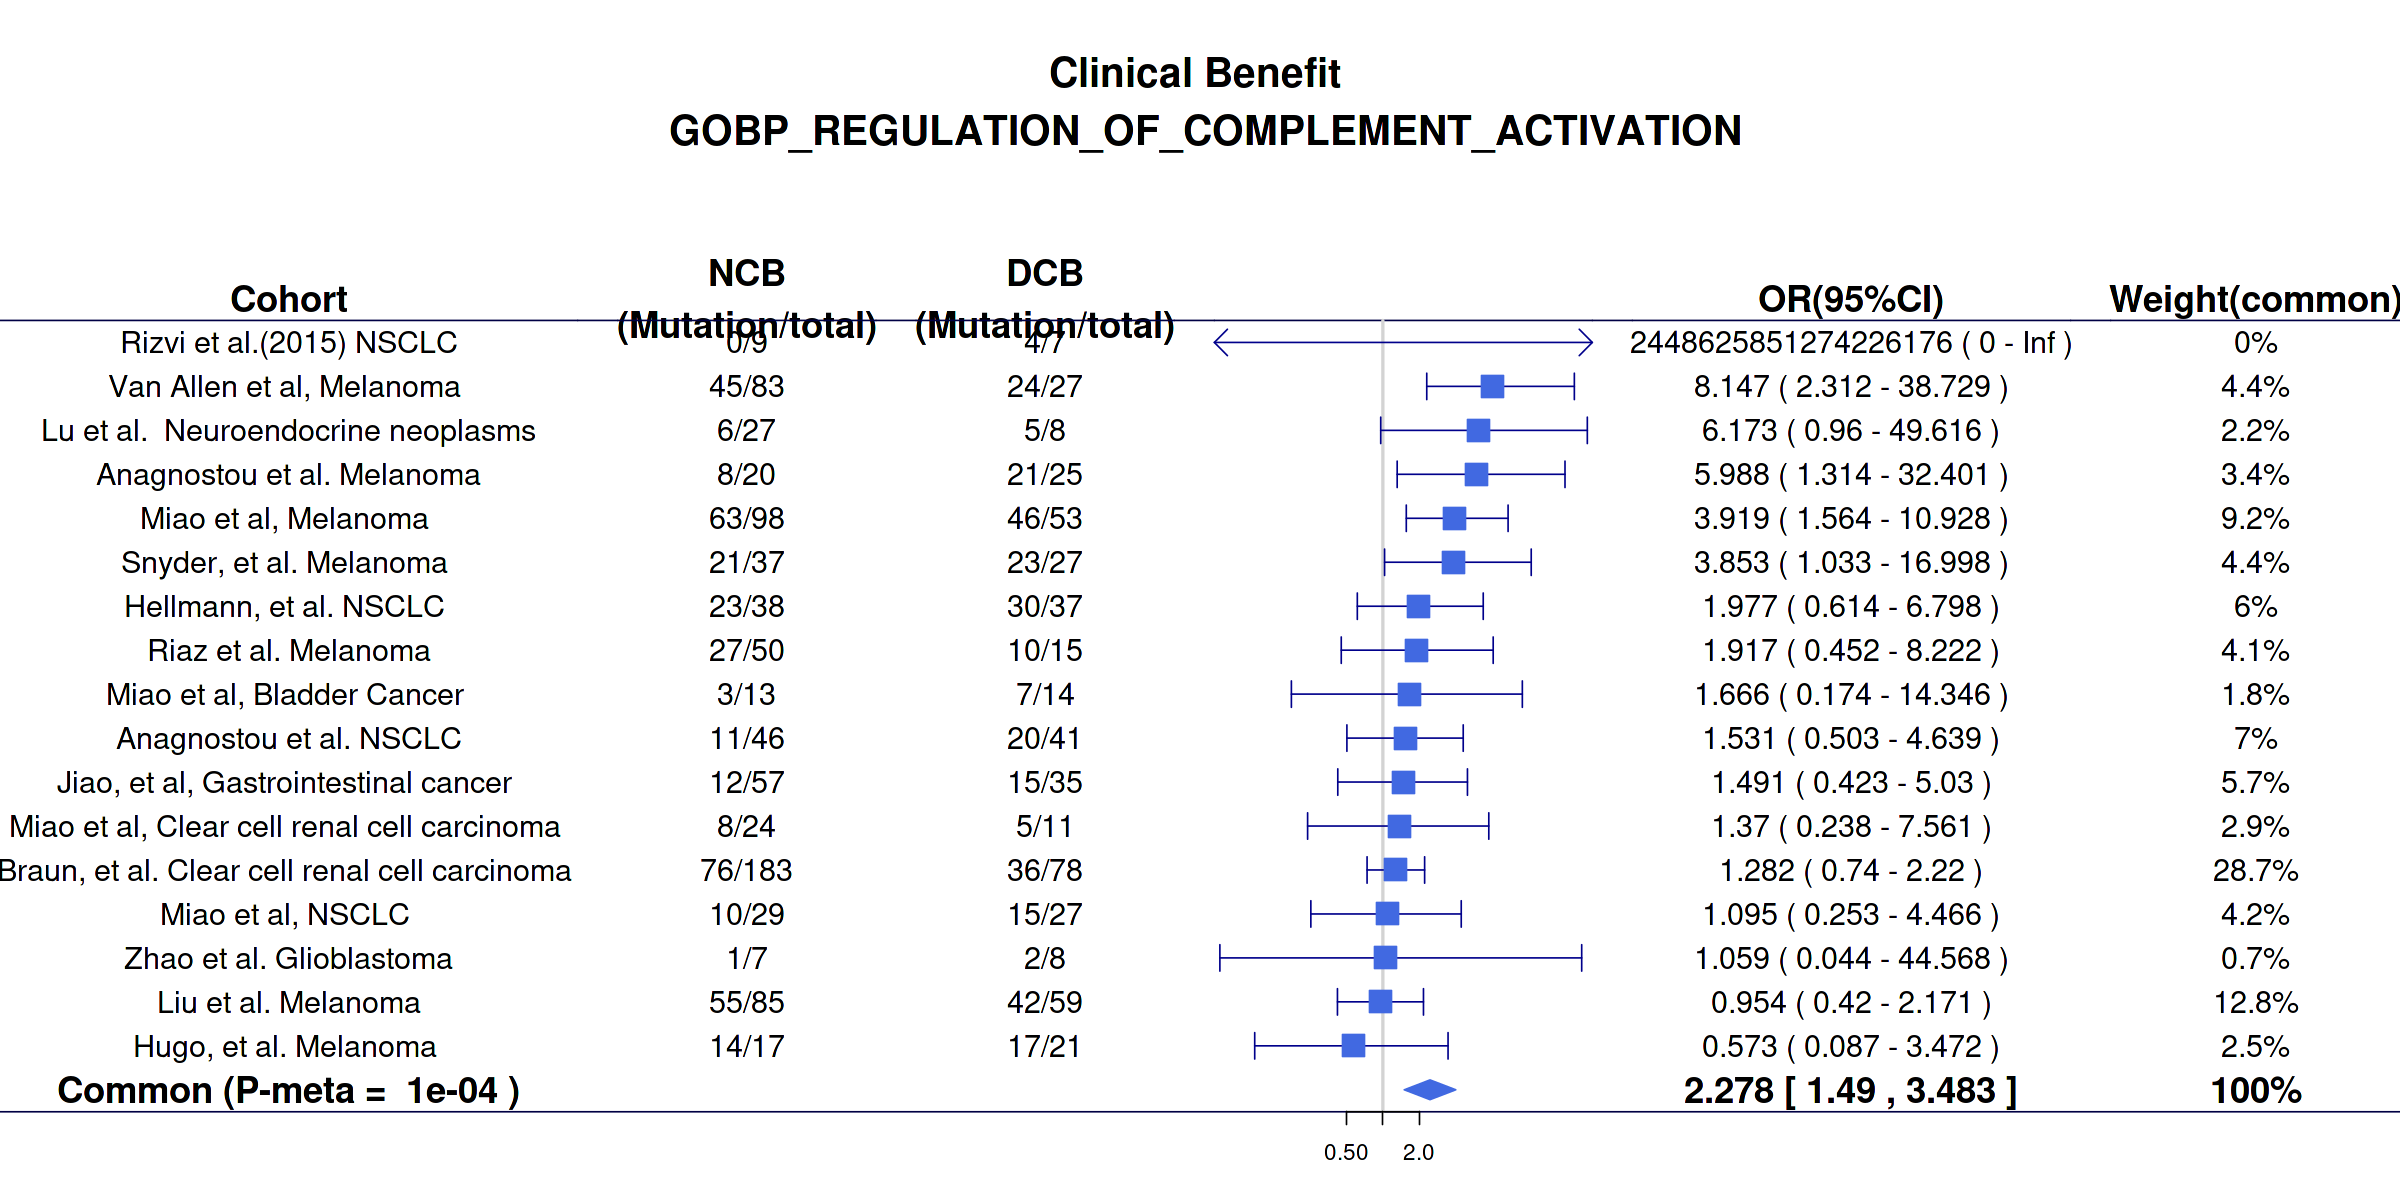

In [187]:
ord = order(OR_mean,decreasing = T)
tabletext = cbind(
    c(NA,"Cohort",cohort[ord],"Common","Random"),
    c(NA,"NCB\n(Mutation/total)",NCB[ord],NA,NA),
    c(NA,"DCB\n(Mutation/total)",DCB[ord],NA,NA),
    c(NA,"OR(95%CI)",OR_text[ord],NA,NA)
#     c(NA,"P value\n(midp.exact)",midp.exact[ord],NA,NA),
#     c(NA,"P value\n(chi.square)",chi.square[ord],NA,NA),
#     c(NA,"P value\n(fisher.exact)",fisher.exact[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,OR_mean[ord],NA,NA),"lower" = c(NA,NA,OR_lower[ord],NA,NA),"upper" = c(NA,NA,OR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "OR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.random,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.random,digits = 4),")")
    }


    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.common,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.common,digits = 4),")")
    }

}

maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

  tmp_list = list()
  tmp_list[["3"]] = gpar(col = "#000044")
  tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

  options(repr.plot.height = 10, repr.plot.width = 20)
  p = cochrane_from_rmeta2 %>%
    forestplot(labeltext = tabletext2,clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
               
                lty.ci = 1,
                ci.vertices.height = 0.3,
                align="c",
                graphwidth = unit(8,"cm"),
                lwd.zero = gpar(lwd=2,lty=2),
               txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
               boxsize = 0.5,
               graph.pos = 4,
               title = paste("Clinical Benefit","\n","GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"),
               is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
               xlog = TRUE,
               hrzl_lines = tmp_list,
               vertices = TRUE,
               col = fpColors(box = "royalblue",
                              line = "darkblue",
                              summary = "royalblue")
    )
  print(p)

In [189]:
ref_cohort_cal_pm = function(dataset,pathway,dataset_mu,Mut_type,Wild_type){
  
  genes = intersect(colnames(dataset),pathway_list[[pathway]])
  
  if("All" %in% Mut_type){
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes
    ])
    
  }else{
    
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes & 
        dataset_mu$Variant_Classification %in% Mut_type
    ])
    
    
    
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),mut)
  }else{
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),unique(dataset_mu$ID[dataset_mu$Hugo_Symbol %in% genes]))
  }
  
  return(list("mut"=mut,"wt"=wt))
  
}

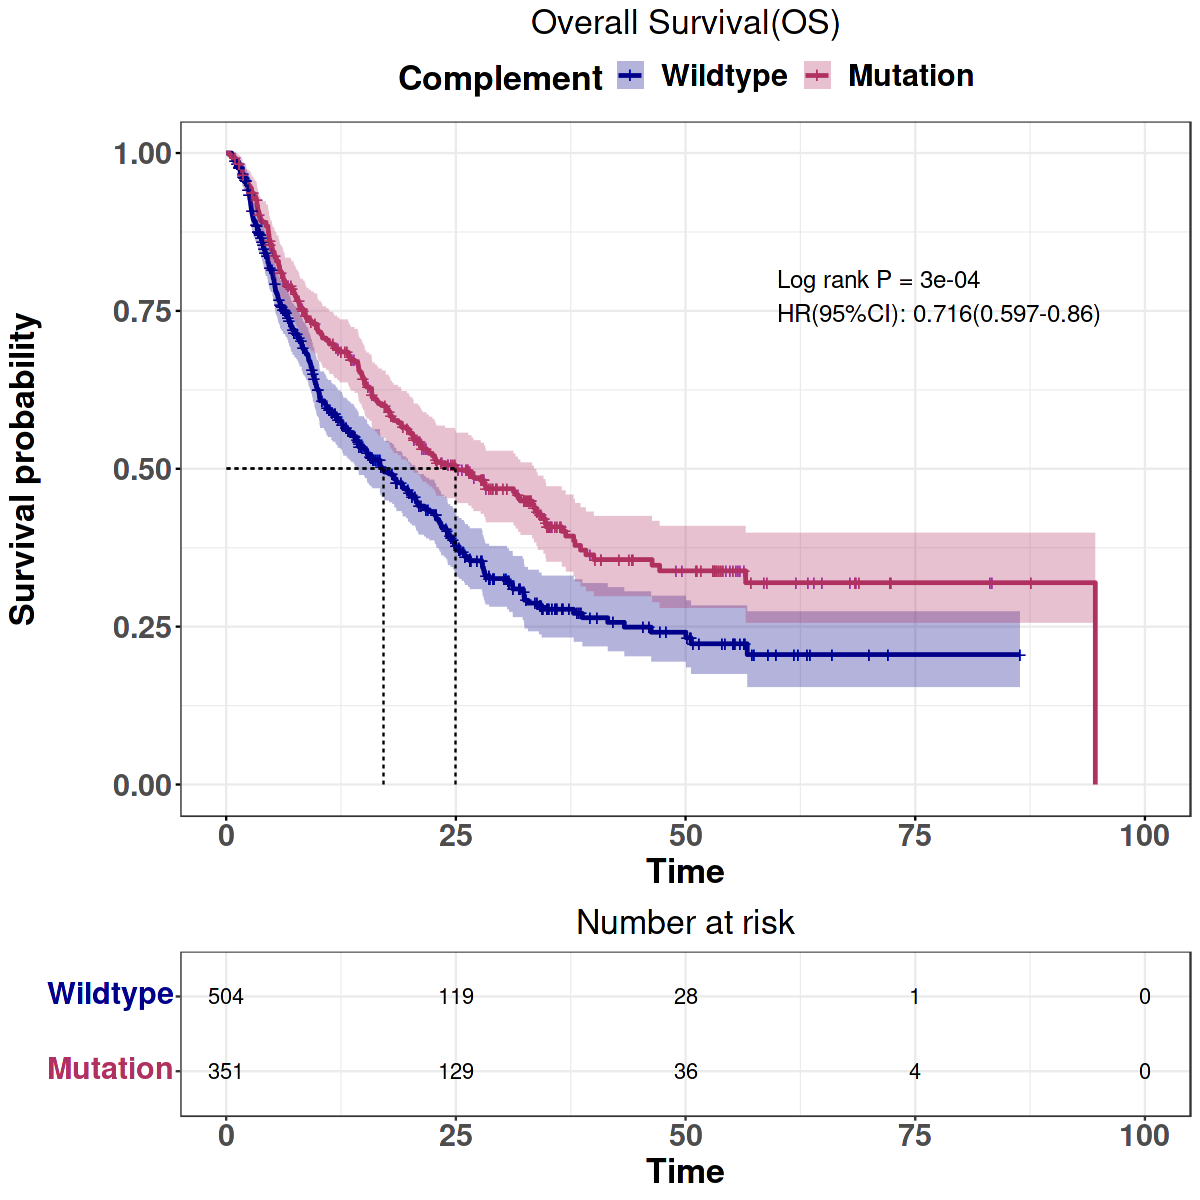

In [190]:
OS_total = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      tmp_cohort2 = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3) 
      tmp_cohort$wt = intersect(tmp_cohort$wt,tmp_cohort2$low)
      tmp_cohort$mut = intersect(tmp_cohort$mut,tmp_cohort2$low)
    if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("OS_TIME" %in% colnames(All[[i]]))){
        tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
#         print(i)
#         print(summary(tmp_data$OS_TIME))
        OS_total = rbind(OS_total,tmp_data)

      }
    }
OS_total = OS_total[!is.na(OS_total$groups),]

fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = OS_total))
data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = OS_total))
p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = OS_total))
HR = round(summary(coxres)$conf.int[,c(1,3,4)],3)
      
p1 = ggsurvplot(fit,data = OS_total,
                pval = paste("\n","Log rank P = ",p.val,"\n","HR(95%CI): ",HR[1],"(",HR[2],"-",HR[3],")",sep = ""),
#                 conf.int.style = "step",
                conf.int = TRUE,
                surv.median.line = "hv",
                pval.coord = c(60, 0.8),
                risk.table = T,
                cumevents = F,
                palette = c("darkblue", "maroon"),
                title=paste("Overall Survival(OS)"),
                legend.title="Complement",
                legend.labs = c("Wildtype","Mutation"),
                ggtheme = theme_bw()+theme(plot.title = element_text(hjust = 0.5,size = 20),legend.position = "right",
                                           legend.title = element_text(size = 20,face="bold"),
                                           legend.text = element_text(size=18,face="bold"),
                                           axis.text = element_text(size=18,face="bold"),
                                           axis.title = element_text(size = 20,face="bold"))
)
tmp_table = p1$table + theme(axis.title.y = element_blank())
p1$table = tmp_table
options(repr.plot.height = 10, repr.plot.width = 10)
return(p1)

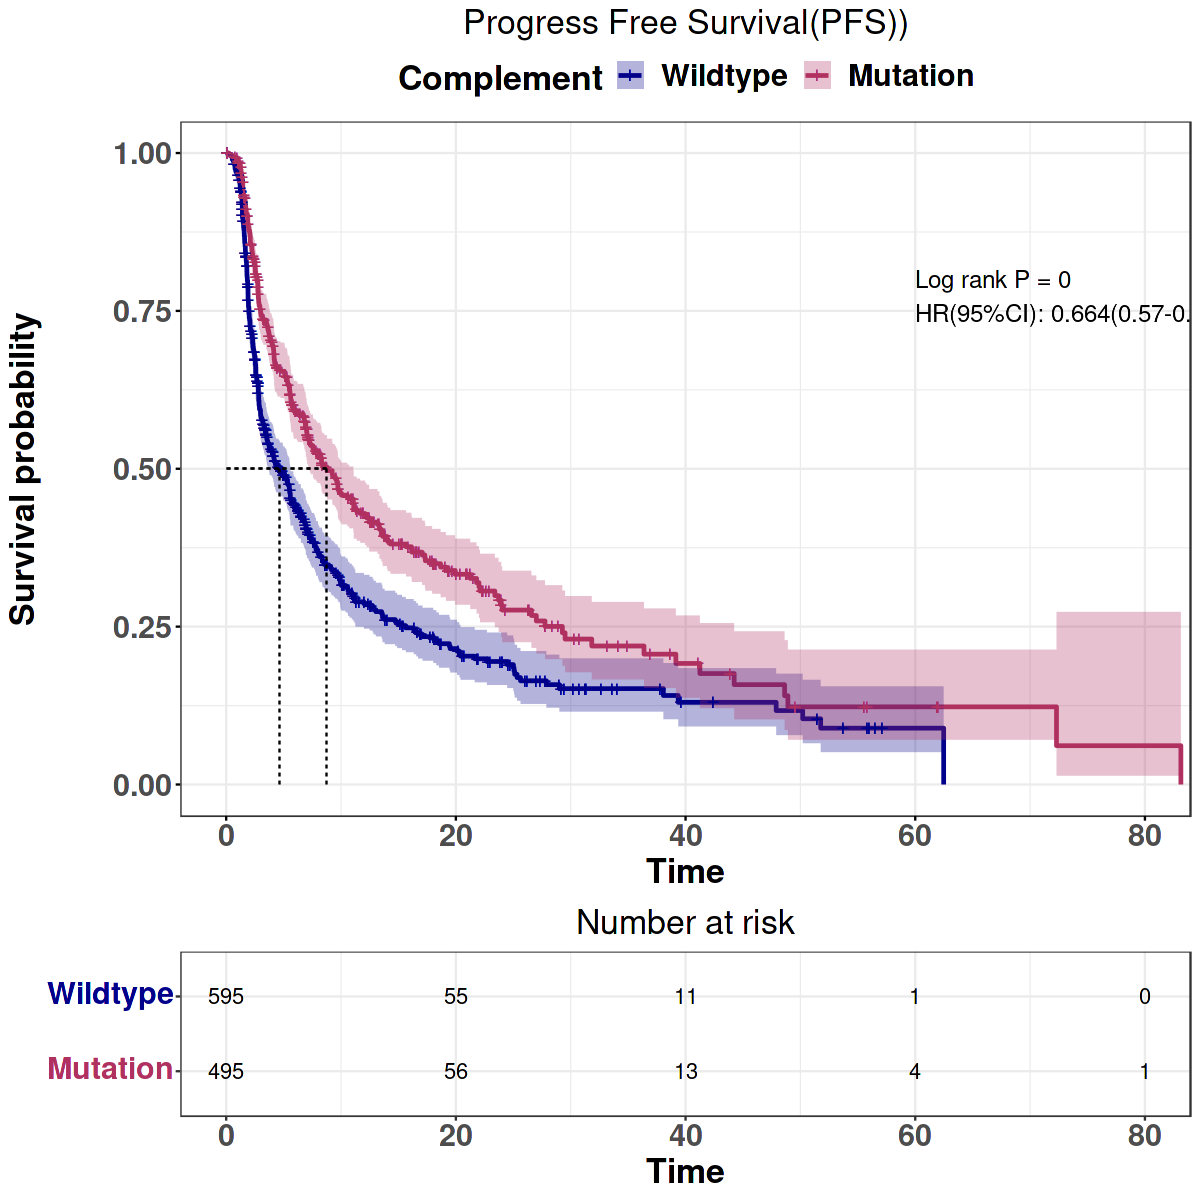

In [191]:
PFS_total = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      tmp_cohort2 = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3) 
      tmp_cohort$wt = intersect(tmp_cohort$wt,tmp_cohort2$low)
      tmp_cohort$mut = intersect(tmp_cohort$mut,tmp_cohort2$low)
    
    if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("PFS_TIME" %in% colnames(All[[i]]))){
        tmp_data = All[[i]][,c("PFS_TIME","PFS_STATUS")]
        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
#         print(i)
#         print(summary(tmp_data$PFS_TIME))
        PFS_total = rbind(PFS_total,tmp_data)

      }
    }
PFS_total = PFS_total[!is.na(PFS_total$groups),]
fit <- do.call(survfit, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = PFS_total))
data.survdiff <- do.call(survdiff, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = PFS_total))
p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
coxres <- do.call(coxph, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = PFS_total))
HR = round(summary(coxres)$conf.int[,c(1,3,4)],3)

p1 = ggsurvplot(fit,data = PFS_total,
                pval = paste("\n","Log rank P = ",p.val,"\n","HR(95%CI): ",HR[1],"(",HR[2],"-",HR[3],")",sep = ""),
#                 conf.int.style = "step",
                conf.int = TRUE,
                surv.median.line = "hv",
                pval.coord = c(60, 0.8),
                risk.table = T,
                cumevents = F,
                palette = c("darkblue", "maroon"),
                title=paste("Progress Free Survival(PFS))"),
                legend.title="Complement",
                legend.labs = c("Wildtype","Mutation"),
                ggtheme = theme_bw()+theme(plot.title = element_text(hjust = 0.5,size = 20),legend.position = "right",
                                           legend.title = element_text(size = 20,face="bold"),
                                           legend.text = element_text(size=18,face="bold"),
                                           axis.text = element_text(size=18,face="bold"),
                                           axis.title = element_text(size = 20,face="bold"))
)
tmp_table = p1$table + theme(axis.title.y = element_blank())
p1$table = tmp_table
options(repr.plot.height = 10, repr.plot.width = 10)
return(p1)

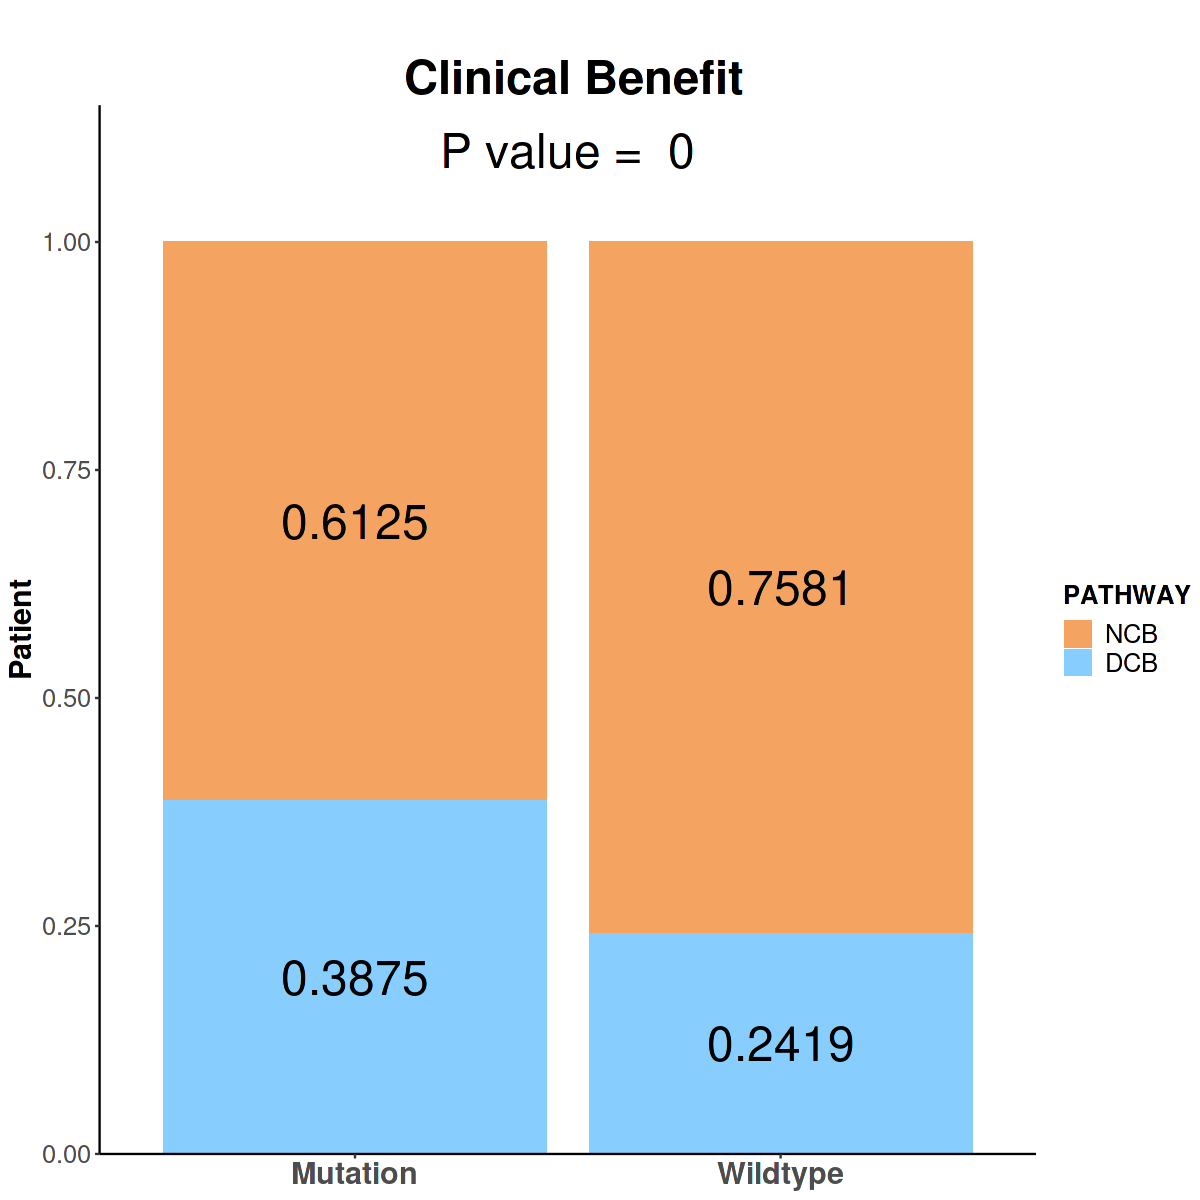

In [192]:
CB_total = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_POST_EMBRYONIC_DEVELOPMENT",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
    tmp_cohort2 = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3) 
    tmp_cohort$wt = intersect(tmp_cohort$wt,tmp_cohort2$low)
    tmp_cohort$mut = intersect(tmp_cohort$mut,tmp_cohort2$low)
    if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RESPONSE" %in% colnames(All[[i]]))){

    
      
    tmp_data = All[[i]][c("RESPONSE")]
    colnames(tmp_data) = "CB"

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
#     tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
    tmp_data$dataset = i
    CB_total = rbind(CB_total,tmp_data)
    
  }else if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RECIST" %in% colnames(All[[i]])) &
           ! i %in% rownames(datasets_overview)[datasets_overview$RESPONSE + datasets_overview$RECIST == 2]){
      
    
      
    tmp_data = All[[i]][c("RECIST")]
    colnames(tmp_data) = "CB"

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
#     tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
    tmp_data$CB = ifelse( tmp_data$CB %in% "PD/SD","nonresponse",ifelse( tmp_data$CB %in% "CR/PR","response",NA))
    tmp_data$dataset = i
    CB_total = rbind(CB_total,tmp_data)
  }
}
CB_total = CB_total[!is.na(CB_total$groups),]

contingency = table(CB_total$groups,CB_total$CB)
rc = rowSums(contingency)
tmp_ma = as.data.frame.matrix(contingency/rc)

if(sum(contingency)<40){
    pvalue = fisher.test(contingency)$p.value
}else{
    tmp_chi = chisq.test(contingency,correct = F)
    
if(sum(tmp_chi$expected < 1) > 0){
    pvalue = fisher.test(contingency)$p.value
}else if(sum(tmp_chi$expected < 5) > 0){
    pvalue = chisq.test(contingency,correct = TRUE)$p.value
}else{pvalue = chisq.test(contingency,correct = FALSE)$p.value}
    }


values = c(tmp_ma[,1],tmp_ma[,2])
g1 = c("Mutation","Wildtype","Mutation","Wildtype")
g2 = c("NCB","NCB","DCB","DCB")
data = data.frame("Genetype" = g1,"CR_PR_ratio" = values,"response" = g2)
data$response = factor(data$response,levels = c("NCB","DCB"))


      p = ggplot(data = data)+
          ggtitle(paste("\n","Clinical Benefit"))+
          geom_bar(mapping = aes(x = Genetype,y = CR_PR_ratio,fill = response),stat = 'identity', position = 'stack')+
          geom_text(aes(x = Genetype,y = CR_PR_ratio,group = response,label = round(CR_PR_ratio,4)),size = 10,stat = "identity", position = position_stack(0.5))+
          theme_classic()+
          scale_y_continuous(expand = c(0,0),limits = c(0,1.15),breaks = c(0,0.25,0.5,0.75,1))+
          scale_fill_manual(values = c("sandybrown","skyblue1"))+
          annotate("text",x = 1.5,y = 1.1,label = paste("P value = ",round(pvalue,digits = 4)),size = 10)+
          labs(fill = "PATHWAY")+
          ylab("Patient")+
          theme(
            plot.title = element_text(hjust = 0.5,size = 28,face = "bold",margin=margin(0,0,0,0)),
            axis.text.x = element_text(size = 18,face = "bold"),
            axis.title.x.bottom = element_blank(),
            axis.title.y = element_text(size = 18,face = "bold"),
            axis.text.y.left = element_text(size = 15),
            legend.text = element_text(size = 15),
            legend.title = element_text(size = 15,face = "bold"),
            legend.position = "right")
options(repr.plot.height = 10, repr.plot.width = 10)
print(p)